In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [ ]:
train_data_dir  = '/content/drive/MyDrive/Final year Project/dataset/train'

classes = os.listdir(train_data_dir)
print(classes)

['metal', 'pp', 'trash', 'pet', 'pe-hd', 'plastic', 'cardboard', 'glass', 'paper', 'ps']


In [ ]:
len(classes)

10

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor()])

train_ds = ImageFolder(train_data_dir, transform = transformations)

In [ ]:
# average  = torch.Tensor([0,0,0])
# standard_dev = torch.Tensor([0,0,0])
# count =0

# for image in train_ds:
#   average += image[0].mean([1,2])
#   standard_dev += image[0].std([1,2])
#   count += 1
#   print(count)

In [ ]:
def show_img(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  pet (5)


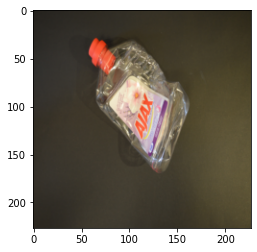

In [ ]:
img, label = train_ds[2222]
show_img(img, label)

In [ ]:
# stats = ((average / len(train_ds)).tolist(), (standard_dev / len(train_ds)).tolist())
# stats

([0.41108962893486023, 0.38021320104599, 0.33871954679489136],
 [0.1553582102060318, 0.1519845724105835, 0.1513998955488205])

In [ ]:
stats = ([0.41108962893486023, 0.38021320104599, 0.33871954679489136],
 [0.1553582102060318, 0.1519845724105835, 0.1513998955488205])

In [ ]:
train_tfms = transforms.Compose([transforms.Resize((227, 227)),
                          transforms.RandomHorizontalFlip(), 
                          transforms.ToTensor(), 
                          transforms.Normalize(*stats,inplace=True)
                        ])
valid_tfms = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize(*stats)
                        ])
test_tfms = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor(), transforms.Normalize(*stats)
                        ])
           

In [ ]:
data_dir = "/content/drive/MyDrive/Final year Project/dataset"

In [ ]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
val_ds = ImageFolder(data_dir+'/val', valid_tfms)
test_ds = ImageFolder(data_dir+'/test', test_tfms)

In [ ]:
batch_size = 128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch.nn as nn

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
import torchvision.models as models

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(train_ds.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))



In [ ]:
model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
import torch.nn.functional as F

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.2825186252593994, 'val_acc': 0.267578125}

In [ ]:
num_epochs = 12
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.8864, val_loss: 1.8196, val_acc: 0.6006
Epoch 2: train_loss: 1.6109, val_loss: 1.6442, val_acc: 0.7370
Epoch 3: train_loss: 1.5473, val_loss: 1.5713, val_acc: 0.8754
Epoch 4: train_loss: 1.5137, val_loss: 1.5239, val_acc: 0.8959
Epoch 5: train_loss: 1.4946, val_loss: 1.5191, val_acc: 0.9434
Epoch 6: train_loss: 1.4799, val_loss: 1.5113, val_acc: 0.9272
Epoch 7: train_loss: 1.4730, val_loss: 1.4979, val_acc: 0.9756
Epoch 8: train_loss: 1.4696, val_loss: 1.4946, val_acc: 0.9746
Epoch 9: train_loss: 1.4685, val_loss: 1.5014, val_acc: 0.9408
Epoch 10: train_loss: 1.4661, val_loss: 1.4890, val_acc: 0.9795
Epoch 11: train_loss: 1.4653, val_loss: 1.4924, val_acc: 0.9448
Epoch 12: train_loss: 1.4648, val_loss: 1.5023, val_acc: 0.9399


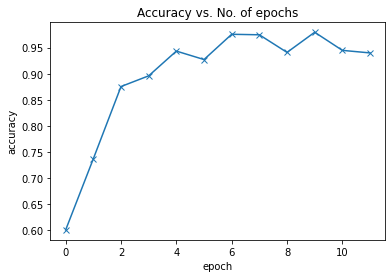

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

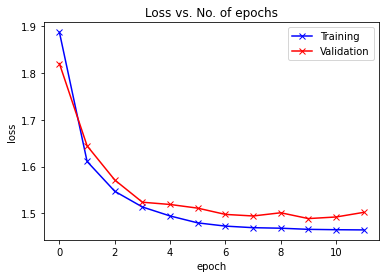

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
model_path = "/content/drive/MyDrive/Final year Project/model_state_1_dec.pt"

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
torch.save(model, "/content/drive/MyDrive/Final year Project/full_model_1_dec.pt")

In [ ]:
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
class VGG(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(train_ds.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))



In [ ]:
model_2 = VGG()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model_2, device)

VGG(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [ ]:
model_2 = to_device(VGG(), device)

In [ ]:
import torch.nn.functional as F

In [ ]:
evaluate(model_2, val_dl)

{'val_loss': 2.302233934402466, 'val_acc': 0.0736607164144516}

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 5.5e-5

history_2 = fit(num_epochs, lr, model_2, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history_2)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history_2)

In [ ]:
torch.save(model, "/content/drive/MyDrive/Final year Project/asdasd.pt")